By: David Santiago Flórez Alsina 😈

-----------------


In [1]:
import plotly
import geopandas
import pandas   as pd
import numpy    as np 
import sympy    as sp
import seaborn  as sns
import plotly.express       as px
import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import scipy.integrate      as integrate

from copy           import deepcopy
from typing         import List, Tuple
from scipy.spatial  import Voronoi, voronoi_plot_2d

In [2]:
import plotly.io as pio
import plotly.offline as pyo

pio.renderers.default = 'notebook'
pyo.init_notebook_mode(connected=True)

## mausqui herramientas misteriosas

In [3]:
def norm(x):
    return sp.sqrt(np.dot(x, x).simplify())

def get_all_from_parametric_curve_with_normalizations(curve: Tuple, var: sp.Symbol):
    """
        Returns a tuple with the following elements:
        - da: first derivative of the curve
        - dda: second derivative of the curve
        - k: curvature of the curve
        - norm_da: norm of the first derivative of the curve
        - norm_dda: norm of the second derivative of the curve

        Input:
        ----------------------------
        - curve: tuple with the parametric curve
        - var: variable of the parametric curve
    """

    da = (sp.diff(curve[0], var), sp.diff(curve[1], var), sp.diff(curve[2], var))
    dda = (sp.diff(curve[0], var, 2), sp.diff(curve[1], var, 2), sp.diff(curve[2], var, 2))
    ddda = (sp.diff(curve[0], var, 3), sp.diff(curve[1], var, 3), sp.diff(curve[2], var, 3))
    norm_da = norm(da)
    norm_dda = norm(dda)

    binorm_vec = np.cross(da, dda)
    binom_vec_norm = norm(binorm_vec)
    k = binom_vec_norm / (norm_da**3)

    unit_da = (da[0]/norm(da), da[1]/norm(da), da[2]/norm(da))
    unit_dda = (dda[0]/norm(dda), dda[1]/norm(dda), dda[2]/norm(dda))
    unit_binorm_vec = (binorm_vec[0]/norm(binorm_vec), binorm_vec[1]/norm(binorm_vec), binorm_vec[2]/norm(binorm_vec))

    #torsion = np.dot(unit_binorm_vec, unit_dda).simplify()
    torsion = -(np.dot(np.cross(da, dda), ddda) / (norm(np.cross(da, dda))**2)).simplify()

    return {'da':               da,
            'dda':              dda,
            'ddda':             ddda,
            'binorm_vec':       binorm_vec,
            'k':                k,
            'torsion':          torsion,
            'norm_da':          norm_da,
            'norm_dda':         norm_dda, 
            'binom_vec_norm':   binom_vec_norm, 
            'unit_da':          unit_da,
            'unit_dda':         unit_dda,
            'unit_binorm_vec':  unit_binorm_vec}

In [4]:
def check_if_curve_is_regular(norm_da, vars):
    """
        Returns True if the curve is regular, False otherwise.

        Input:
        ----------------------------
        - da: first derivative of the curve
    """

    #find roots of norm_da function if any
    roots = sp.solve(norm_da, vars)

    #if there are no roots, the curve is regular
    if len(roots) == 0:
        return True
    else:
        return False


In [5]:
def calculate_rotation_index_from_non_parametric(k, da_norm, var, start, end):
    """
        Returns the rotation index of a non-parametric curve.
    """
    rotation_index = sp.integrate(k*da_norm, (var, start, end))*(1/(2*sp.pi))
    return rotation_index.simplify()

def calculate_rotation_index_from_non_parametric_numeric(k, da_norm, var, start, end):
    """
        Returns the rotation index of a non-parametric curve.
        By using numeric integration.
    """

    integration_fn = lambda x: k(x)*da_norm(x)*(1/(2*np.pi))

    rotation_index = integrate.quad(integration_fn, start, end)
    return rotation_index

In [6]:
def calculate_rotation_index_from_parametric(k, var, start, end):
    """
        Returns the rotation index of parametric curve
    """
    rotation_index = sp.integrate(k, (var, start, end))*(1/(2*sp.pi))
    return rotation_index.simplify()

def calculate_rotation_index_from_parametric_numeric(k, var, start, end):
    """
        Returns the rotation index of parametric curve
        By using numeric integration.
    """
    integration_fn = lambda x: k(x)
    rotation_index = integrate.quad(integration_fn, start, end)

    return rotation_index

In [7]:
def calculate_curve_length(delta_curve_norm, var, start, end):
    """
        Returns the length of a curve
    """
    
    curve_length = sp.integrate(delta_curve_norm, (var, start, end))
    return curve_length.simplify()

In [8]:
def plot_arrow_plotly(start_point: np.array,
                      endpoint: np.array,
                      retrieve_fig: bool = True, 
                      name: str = '') -> Tuple[go.Figure, List]:

    end_point = go.Cone(
                        x=[endpoint[0]],
                        y=[endpoint[1]],
                        z=[endpoint[2]],
                        u=[endpoint[0] - start_point[0]],
                        v=[endpoint[1] - start_point[1]],
                        w=[endpoint[2] - start_point[2]],
                        colorscale='Blues',
                        sizemode="absolute",
                        sizeref=0.5
                    )

    line = go.Scatter3d(
                        x=[start_point[0], endpoint[0]],
                        y=[start_point[1], endpoint[1]],
                        z=[start_point[2], endpoint[2]],
                        mode='lines',
                        line=dict(
                            color='red',
                            width=4
                        )
                    )

    #add name to the trace, cone and line
    end_point.name = name
    line.name      = name

    fig = go.Figure()
    fig.add_trace(end_point)
    fig.add_trace(line)

    if retrieve_fig:
        return fig
    else:
        return [end_point, line]

Read the data in the link cancer2.csv. This file has measurements of tumor cells; these are diag-
nosed as benign or malignant cells for each case. The scatter plot for the variables “Perimetro”
and “Concavidad” is on the previous page.

# Point 1 
(1 point) Implement the 2D Range Searching algorithm to run a query of the interval
[1000 : 3000] × [500 : 1500] for the variables “Concavidad” and “Perimetro”. Print the
cell IDs for the results of the 2D query. You should implement the algorithm shown in
class; the use of a common filter or a conditional is not the right answer.
Do a scatterplot where points in the query have a different color from those which are
out of the query.


In [9]:
class Point():

    def __init__(self, args: Tuple):
        self.name = None
        self.args = args

    def set_name(self, name: str):  
        self.name = name

    def __repr__(self):
        return f'Point({self.args})'

    def __getitem__(self, index):
        return self.args[index]

    def __len__(self):
        return len(self.args)

class Node():

    def __init__(self, point: Point, left: 'Node' = None, right: 'Node' = None):
        self.point = point
        self.left = left
        self.right = right

    @property
    def is_leaf(self):
        return self.left is None and self.right is None

    def __repr__(self):
        return f'Node({self.point})'
    
    def __getitem__(self, index):
        return self.point[index]
    
    def __len__(self):
        return len(self.point)

class Region():

    def __init__(self, limits: List[Tuple]):
        self.limits = limits

    def __repr__(self):
        return f'Region({self.limits})'
    
    def __getitem__(self, index):
        return self.limits[index]

    def __len__(self):
        return len(self.limits)

    def inside_region(self, point: Point):
        """
            Returns True if the point is inside the region, False otherwise.
        """
        for i in range(len(self.limits)):
            if not (self.limits[i][0] <= point[i] <= self.limits[i][1]):
                return False
        return True


    @staticmethod 
    def get_region_from_points(points: List[Point]) -> 'Region':
        """
            Returns a list of tuples with the limits of the region.
        """
        limits = []

        for cord in range(len(points[0])):
            minumum_lim = min([point[cord] for point in points])
            maximum_lim = max([point[cord] for point in points])
            limits.append((minumum_lim, maximum_lim))

        return Region(limits)

    @staticmethod
    def contained(main_region: 'Region', other_region: 'Region'):

        #checks if the limits of the other region are inside the limits of the main region
        for i in range(len(main_region)):
            bounded_by = (main_region[i][0] <= other_region[i][0] <= main_region[i][1]) and (main_region[i][0] <= other_region[i][1] <= main_region[i][1])
            if not bounded_by:
                return False
        return True

    @staticmethod
    def intersects(main_region: 'Region', other_region: 'Region'):
        
        #check if any intersection exists
        for i in range(len(main_region)):
            if (main_region[i][0] <= other_region[i][0] <= main_region[i][1]) or (main_region[i][0] <= other_region[i][1] <= main_region[i][1]):
                return True
            
        return False

In [10]:
class KDTree():

    def __init__(self, points: List[Point], depth: int):
        self.points = points
        self.depth = depth
        self.root = self.build()

    @property
    def left(self):
        return self.root.left
    
    @property
    def right(self):
        return self.root.right

    def build(self) -> Node:

        if len(self.points) == 1:
            return Node(self.points[0])

        #if depth is even
        elif self.depth % 2 == 0:

            #split points into two groups with a vertical line through the median x-coordinate
            #of the points
            median_x = np.median([point[0] for point in self.points])

            left_points = [point for point in self.points if point[0] <= median_x]
            right_points = [point for point in self.points if point[0] > median_x]

        #if depth is odd
        else:

            # split points into two groups with a horizontal line through the median y-coordinate
            # of the points
            median_y = np.median([point[1] for point in self.points])

            left_points = [point for point in self.points if point[1] <= median_y]
            right_points = [point for point in self.points if point[1] > median_y]

        #create left and right subtrees
        left_subtree = KDTree(left_points, self.depth + 1)
        right_subtree = KDTree(right_points, self.depth + 1)

        return Node(self.points[0], left_subtree.root, right_subtree.root)

    @staticmethod
    def inorder_traversal(root: Node) -> List[Point]:

        if root is None:
            return []

        return KDTree.inorder_traversal(root.left) + [root.point] + KDTree.inorder_traversal(root.right)


    @staticmethod
    def region_search(root: Node, search_region: Region) -> List[Point]:
        """
            Returns a list with the points inside the search region.
        """

        points_inside_region = []

        #if region is inside the search region, add it to the list
        if search_region.inside_region(root.point):
            points_inside_region.append(root.point)

        #if left subtree is not None, search it
        if root.left is not None:
            points_inside_region += KDTree.region_search(root.left, search_region)

        #if right subtree is not None, search it
        if root.left is not None:
            points_inside_region += KDTree.region_search(root.right, search_region)

        return points_inside_region

    @staticmethod
    def search_kd_tree(root: Node, search_region: Region, output: List):
        """
            Returns the points inside the search region.
        """

        if root.is_leaf:
            if search_region.inside_region(root.point):
                print(f"point {root.point} inside search region: {search_region}\n")
                output += [root.point,]

        #if left subtree is not None, search it
        if root.left is not None:
            print(f"search over left subtree: {root.left}")

            left_nodes = KDTree.inorder_traversal(root.left)
            left_child_region = Region.get_region_from_points(left_nodes)

            #if left child region is fully contained in search region, add all the points
            if Region.contained(search_region, left_child_region):
                print(f"left child region fully contained in search region: {left_child_region}")
                output += left_nodes

            #if left child region is partially contained in search region, search inside it
            elif Region.intersects(search_region, left_child_region):
                print(f"left child region partially contained in search region: {left_child_region}")
                KDTree.search_kd_tree(root.left, search_region, output)

            #if left child region is not contained in search region, do nothing
            else:
                print(f"left child region not contained in search region: {left_child_region}\n")

        #if right subtree is not None, search it
        if root.right is not None:
            print(f"search over right subtree: {root.right}")

            right_nodes = KDTree.inorder_traversal(root.right)
            right_child_region = Region.get_region_from_points(right_nodes)

            #if the right child region is fully contained in the search region, add all the points
            if Region.contained(search_region, right_child_region):
                print(f"right child region fully contained in search region: {right_child_region}")
                output += right_nodes

            #if the right child region is partially contained in the search region, search inside it
            elif Region.intersects(search_region, right_child_region):
                print(f"right child region partially contained in search region: {right_child_region}")
                KDTree.search_kd_tree(root.right, search_region, output)

            #if the right child region is not contained in the search region, do nothing
            else:
                print(f"right child region not contained in search region: {right_child_region}\n")

In [11]:
#read the data
data = pd.read_csv('cancer2.csv')[['Concavidad', 'Perimetro']].values

#build a list of points
points = [Point(point) for point in data]

#add the ids to the points
ids = pd.read_csv('cancer2.csv')[['ID']].values
for i in range(len(points)):
    points[i].set_name(ids[i][0])

#build the tree
tree = KDTree(points, 0)
tree.root

#search range 
search_range = Region([(1000, 3000), (500, 1500)])

#search the tree
#points_inside_region = tree.region_search(tree.root, search_range)
points_inside_region = []
tree.search_kd_tree(tree.root, search_range, points_inside_region)

search over left subtree: Node(Point([ 869 1329]))
left child region partially contained in search region: Region([(0, 2531), (63, 9958)])
search over left subtree: Node(Point([ 869 1329]))
left child region partially contained in search region: Region([(0, 2508), (63, 6021)])
search over left subtree: Node(Point([ 869 1329]))
left child region partially contained in search region: Region([(0, 1478), (63, 5982)])
search over left subtree: Node(Point([1354  107]))
left child region partially contained in search region: Region([(17, 1478), (63, 1184)])
search over left subtree: Node(Point([1063  884]))
left child region partially contained in search region: Region([(17, 1063), (63, 1184)])
search over left subtree: Node(Point([1063  884]))
left child region partially contained in search region: Region([(17, 1063), (63, 1038)])
search over left subtree: Node(Point([  17 1003]))
left child region partially contained in search region: Region([(17, 255), (63, 1038)])
search over left subtree

In [12]:
#show the points inside the region
print(points_inside_region)

#show the points ID inside the region
print([point.name for point in points_inside_region])

[Point([1044  719]), Point([1063  884]), Point([1043 1062]), Point([1036 1151]), Point([1267  974]), Point([1307  646]), Point([1307  646]), Point([1342  786]), Point([1122 1002]), Point([1122 1002]), Point([1147 1026]), Point([1122 1002]), Point([1191 1028]), Point([1201 1178]), Point([1201 1178]), Point([1348 1101]), Point([1466 1017]), Point([1466 1017]), Point([1478 1069]), Point([1348 1101]), Point([1348 1101]), Point([1127 1196]), Point([1127 1196]), Point([1193 1263]), Point([1127 1196]), Point([1114 1275]), Point([1114 1275]), Point([1272 1297]), Point([1127 1196]), Point([1335 1211]), Point([1335 1211]), Point([1457 1214]), Point([1323 1255]), Point([1323 1255]), Point([1323 1255]), Point([1379 1265]), Point([1097 1372]), Point([1097 1372]), Point([1155 1311]), Point([1168 1409]), Point([1367 1357]), Point([1367 1357]), Point([1411 1305]), Point([1689  733]), Point([1522 1029]), Point([1683 1024]), Point([1683 1024]), Point([1697 1004]), Point([1722 1081]), Point([1722 1081]),

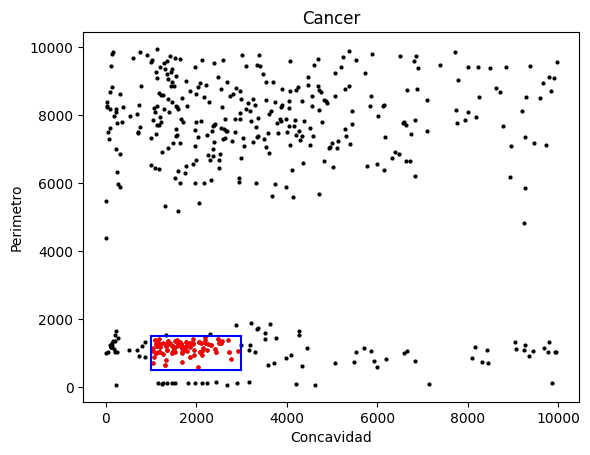

In [13]:
#plot the points
plt.plot(data[:, 0], data[:, 1], 'o', color='black', markersize=2)
plt.plot([point[0] for point in points_inside_region], [point[1] for point in points_inside_region], 'o', color='red', markersize=2)

#plot the search region as a box    
plt.plot([search_range[0][0], search_range[0][0]], [search_range[1][0], search_range[1][1]], color='blue')
plt.plot([search_range[0][1], search_range[0][1]], [search_range[1][0], search_range[1][1]], color='blue')
plt.plot([search_range[0][0], search_range[0][1]], [search_range[1][0], search_range[1][0]], color='blue')
plt.plot([search_range[0][0], search_range[0][1]], [search_range[1][1], search_range[1][1]], color='blue')

#add title and labels
plt.title('Cancer')
plt.xlabel('Concavidad')
plt.ylabel('Perimetro')
plt.show()

------------------
Sometimes, when mechanics fail, flights have to follow an emergency protocol, which includes
landing at the nearest airport. In such cases, knowledge about the Voronoi diagram associated
with the airports is crucial, and according to that, the pilot could update the flight plan by
searching for a faster landing.

Read the data in the link airports CO.csv. This file has coordinates of airports in Colombia.

# Point 2

(0.8 points) Use the libraries Voronoi and voronoi plot 2d and plot the Voronoi diagram
associated with Colombian airports on the map as shown in the figure. It could be useful
for you to explore the links: Voronoi KMeans and Mapas.


In [14]:
airports = pd.read_csv('airports_CO.csv')
airports.head()

,Latitud,Longitud,Altitud,Ciudad,Departamento,Aeropuerto
0,4.244800,-74.649886,492.861639,Melgar,Tolima,Tolemaida Air Base
1,4.216442,-74.635047,313.334425,Melgar,Tolima,Melgar Ab Airport
2,7.927567,-72.511547,334.060826,Cucuta,NorteDeSantander,Camilo Daza Airport
3,4.701594,-74.146947,2548.432820,Bogota,DistritoCapital,Eldorado International Airport
4,5.432780,-71.662500,197.815200,Trinidad,Casanare,Trinidad Airport


We import the map of Colombia

In [15]:
url='https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/3aadedf47badbdac823b00dbe259f6bc6d9e1899/colombia.geo.json'
col = geopandas.read_file(url)
col.head()

,DPTO,NOMBRE_DPT,AREA,PERIMETER,HECTARES,geometry
0,05,ANTIOQUIA,6.335186e+10,1963728.843,6335185.555,"POLYGON ((-76.30730 8.61930, -76.29810 8.61640..."
1,08,ATLANTICO,3.360765e+09,240936.172,336076.535,"POLYGON ((-74.87060 10.36120, -74.87640 10.343..."
2,11,SANTAFE DE BOGOTA D.C,1.650948e+09,323322.540,165094.778,"POLYGON ((-74.02290 4.79510, -74.02640 4.78360..."
3,13,BOLIVAR,2.614189e+10,1309427.968,2614189.453,"POLYGON ((-75.15950 10.42360, -75.15430 10.409..."
4,15,BOYACA,2.335258e+10,1364539.911,2335258.246,"POLYGON ((-72.21300 7.02750, -72.20610 7.02460..."


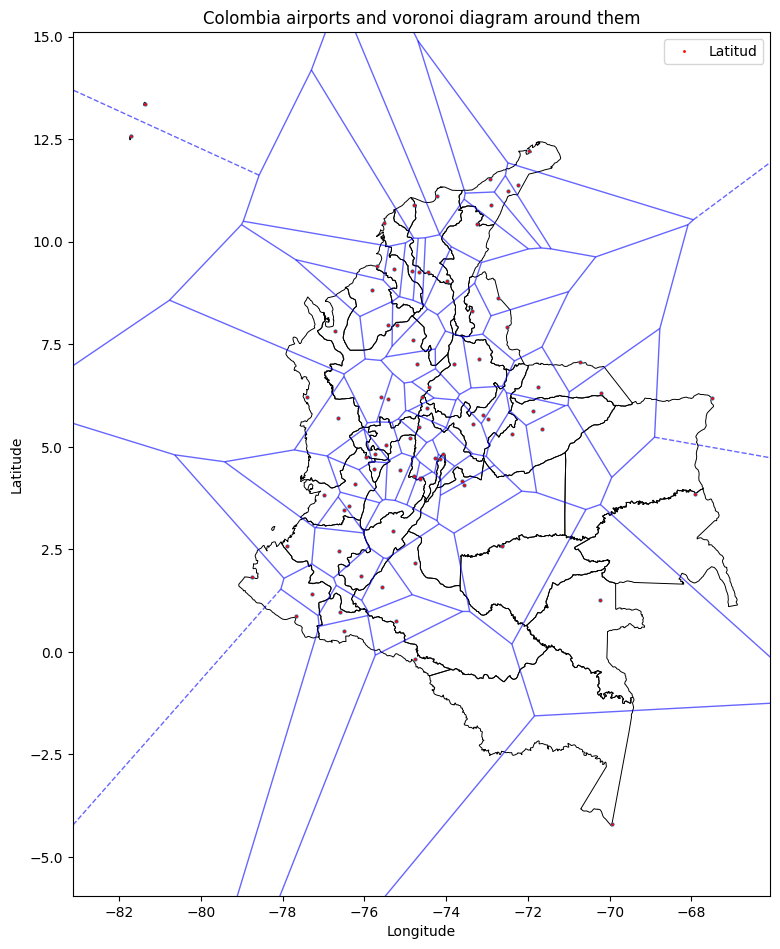

In [16]:
points = airports[['Longitud', 'Latitud']].values
vor = Voronoi(points)

#plotting the colombia map 
fig, ax = plt.subplots(figsize=(9, 16))
col.boundary.plot(ax=ax, color='black', linewidth=0.7)

#plotting the voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1, line_alpha=0.6, point_size=4)

#plotting the airports
airports.plot(x='Longitud', y='Latitud', ax=ax, color='red', markersize=1, style='o')

#adding titles and labels
plt.title('Colombia airports and voronoi diagram around them')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

------------------
# Point 3

(0.8 points) Consider the curve:

$$\alpha(t) = (cos(3t) cos(t),\; cos(3t) sin(t),\; 0),\;\; t \in [0, \pi]$$

### Point 3.1

- Plot the curve $\alpha(t)$  with the tangent vector at $t = 0$.

In [17]:
t     = sp.Symbol('t', real=True)
start = 0
end   = np.pi

# Parametric curve
alpha = (sp.cos(3*t)*sp.cos(t), sp.cos(3*t)*sp.sin(t), 0)
alpha

(cos(t)*cos(3*t), sin(t)*cos(3*t), 0)

Get some extra information about the curve $\alpha(t)$

In [18]:
info = get_all_from_parametric_curve_with_normalizations(alpha, t)
da_alpha = info['da']
da_alpha

(-sin(t)*cos(3*t) - 3*sin(3*t)*cos(t), -3*sin(t)*sin(3*t) + cos(t)*cos(3*t), 0)

In [19]:
# interval of the parameter t
t_vals = np.linspace(start, end, 100)

# lambdify the parametric curve
alpha_fn = sp.lambdify(t, alpha, 'numpy')
da_alpha_fn = sp.lambdify(t, da_alpha, 'numpy')

# evaluate the parametric curve
alpha_vals = alpha_fn(t_vals)

In [20]:
# add the tangent vector at t=0
tangent_vector = np.array(da_alpha_fn(0))
tangent_vector_start = np.array(alpha_fn(0))

fig = plot_arrow_plotly(tangent_vector_start,
                        tangent_vector + tangent_vector_start,
                        name='Tangent vector at t=0')

# 3D plot of the parametric curve, as a line, colored as a parameter of t 
# with the colorbar showing the values of t
fig.add_trace(go.Scatter3d(x=alpha_vals[0],
                           y=alpha_vals[1],
                           z=np.zeros_like(alpha_vals[1]),
                           marker=dict(size=4,
                                       color=t_vals,
                                       colorscale='inferno',),
                           line=dict(color=t_vals,
                                     colorscale='inferno',
                                     width=2), 
                          ))

fig.update_layout(title='Parametric curve',
                  scene=dict(xaxis_title='x',
                             yaxis_title='y',
                             zaxis_title='z'), 
                  width=800,
                  height=800, 
                  margin=dict(l=65, r=50, b=65, t=90), 
                  scene_aspectmode='cube',)

### Point 3.2
- Plot the curvature $\kappa(t)$. 

In [21]:
curvature = info['k']
curvature

2*Abs(64*sin(t)**6 - 96*sin(t)**4 + 36*sin(t)**2 + 5)/(128*sin(t)**6 - 192*sin(t)**4 + 72*sin(t)**2 + 1)**(3/2)

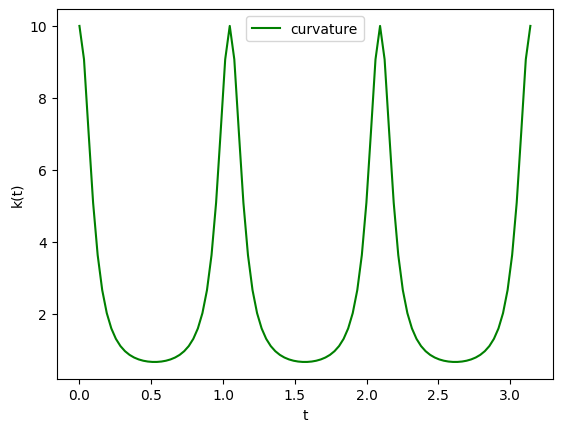

In [22]:
curvature_fn = sp.lambdify(t, curvature, 'numpy')
curvature_vals = curvature_fn(t_vals)

plt.plot(t_vals, curvature_vals, label='curvature', color='green')
plt.ylabel('k(t)')
plt.xlabel('t')
plt.legend()
plt.show()

### Point 3.3
- Evaluate the curve’s length.

In [23]:
da_norm    = info['norm_da']
da_norm_fn = sp.lambdify(t, da_norm, 'numpy')
da_norm

sqrt(128*sin(t)**6 - 192*sin(t)**4 + 72*sin(t)**2 + 1)

In [24]:
curve_length = calculate_curve_length(da_norm, t, start, end)
curve_length

Integral(sqrt(128*sin(t)**6 - 192*sin(t)**4 + 72*sin(t)**2 + 1), (t, 0, 3.14159265358979))

In [25]:
curve_length.evalf()

6.68244661027763

### Point 3.4

Evaluate the rotation index. Use numerical integration if necessary. Interpret your result.

In [26]:
rotation_idx_result = calculate_rotation_index_from_non_parametric_numeric(curvature_fn, da_norm_fn, t, 0, np.pi)

print(f"Rotation index: {rotation_idx_result[0]}, error: {rotation_idx_result[1]}")

Rotation index: 1.999999999999991, error: 2.7787198651234558e-08


As the parameter 't' varies from 0 to π, the curve winds around the specified point in space twice. Each full rotation corresponds to a rotation index of 1, so a rotation index of 2 implies that the curve completes two full rotations around the point, in the interval [0, π], if we were to continue increasing the parameter 't' beyond π until (2π), the curve would have 4 full rotations around the point, and so on.

In the context of this particular parametric curve, which has a 0 value in the z-axis, the rotation index of 2 would indicate that the curve winds around the point in the xy-plane twice. 😈

----------------
# Point 4

(0.8 points) Consider the curve:

$$\alpha(t) = \left( \frac{cos(t)}{1 + sin^{2}(t)},\;\, \frac{sin(t)cos(t)}{1 + sin^{2}(t)},\;\; 0 \right), \;\; t \in [0, 2\pi]$$

### Point 4.1

- Plot the curve $\alpha(t)$  with the tangent vector at $t = 0$.

In [27]:
t = sp.Symbol('t', real=True, positive=True)
start = 0
end   = 2*np.pi

# Parametric curve
alpha = ( sp.cos(t)/(1 + sp.sin(t)**2), sp.sin(t)*sp.cos(t)/(1 + sp.sin(t)**2), 0)
alpha

(cos(t)/(sin(t)**2 + 1), sin(t)*cos(t)/(sin(t)**2 + 1), 0)

In [28]:
info = get_all_from_parametric_curve_with_normalizations(alpha, t)
da_alpha = info['da']
da_alpha

(-sin(t)/(sin(t)**2 + 1) - 2*sin(t)*cos(t)**2/(sin(t)**2 + 1)**2,
 -sin(t)**2/(sin(t)**2 + 1) + cos(t)**2/(sin(t)**2 + 1) - 2*sin(t)**2*cos(t)**2/(sin(t)**2 + 1)**2,
 0)

In [29]:
t_vals = np.linspace(start, end, 100)
t_value = 0

# lambdify the parametric curve
alpha_fn = sp.lambdify(t, alpha, 'numpy')
da_alpha_fn = sp.lambdify(t, da_alpha, 'numpy')

# evaluate the parametric curve
alpha_vals = alpha_fn(t_vals)

In [30]:
# add the tangent vector at t=0
tangent_vector = np.array(da_alpha_fn(t_value))
tangent_vector_start = np.array(alpha_fn(t_value))

fig = plot_arrow_plotly(tangent_vector_start,
                        tangent_vector_start + tangent_vector, 
                        name='Tangent vector at t=0')

# 3D plot of the parametric curve, as a line, colored as a parameter of t 
# with the colorbar showing the values of t
fig.add_trace(go.Scatter3d(x=alpha_vals[0],
                           y=alpha_vals[1],
                           z=np.zeros_like(alpha_vals[1]),
                           marker=dict(size=4,
                                       color=t_vals,
                                       colorscale='inferno',),
                           line=dict(color=t_vals,
                                     colorscale='inferno',
                                     width=2), 
                          ))

fig.update_layout(title='Parametric curve',
                  scene=dict(xaxis_title='x',
                             yaxis_title='y',
                             zaxis_title='z'), 
                  width=800,
                  height=800, 
                  margin=dict(l=65, r=50, b=65, t=90), 
                  scene_aspectmode='cube',)

### Point 4.2
- Plot the curvature $\kappa(t)$.

In [31]:
curvature = info['k']
curvature

sqrt(16*sin(t)**8 - 40*sin(t)**6 + 33*sin(t)**4 + 26*sin(t)**2 - 16*cos(t)**8 + 24*cos(t)**6 + 1)*Abs(cos(t))/(sin(t)**2 + 1)**(3/2)

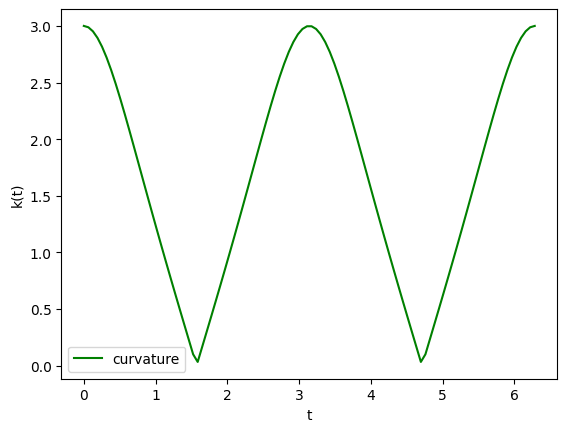

In [32]:
curvature_fn   = sp.lambdify(t, curvature, 'numpy')
curvature_vals = curvature_fn(t_vals)

plt.plot(t_vals, curvature_vals, label='curvature', color='green')
plt.ylabel('k(t)')
plt.xlabel('t')
plt.legend()
plt.show()

### Point 4.3
- Evaluate the curve’s length.

In [33]:
da_norm    = info['norm_da']
da_norm_fn = sp.lambdify(t, da_norm, 'numpy')
da_norm

1/sqrt(sin(t)**2 + 1)

In [34]:
curve_length = calculate_curve_length(da_norm, t, start, end)
curve_length

elliptic_f(6.28318530717959, -1)

In [35]:
curve_length.evalf()

5.24411510858424

### Point 4.4

- Evaluate the rotation index. Use numerical integration if necessary. Interpret your result.

In [36]:
rotation_idx_result = calculate_rotation_index_from_non_parametric_numeric(curvature_fn, da_norm_fn, t, 0, 2*np.pi)

print(f"Rotation index: {rotation_idx_result[0]}, error: {rotation_idx_result[1]}")

Rotation index: 1.5, error: 3.412431448523989e-11


In more detail, we imagine tracing the path of the parametric curve in three dimensions as the parameter 't' varies from 0 to 2π, the rotation index indicates how many times the curve wraps around the point in the xy-plane. A rotation index of 1.5 implies us that the curve completes one full rotation and then continues for half of another rotation.

Since our parametric curve has a 0 value in the z-axis, the rotation index specifically refers to the winding behavior in the xy-plane :D.



----------------
# Point 5

(0.6 points) (1.3 points) Show that torsion $\tau(t)$ for a non-arc length parameterized curve $\alpha(t)$ is given by:

$$\tau(t) = -\frac{(\alpha'(t) \times \alpha''(t)) \cdot \alpha'''(t)}{\|\alpha'(t) \times \alpha''(t)\|^{2}}$$

Include the procedure in your notebook using $\LaTeX$.

#### Remember:

We know that $\alpha'(t)$, $\alpha''(t)$ are orthogonal between them, because by differenciating $\alpha'(t) \cdot \alpha'(t) = 1$ we get that $\alpha'(t) \cdot \alpha''(t) = 0$. This makes sense because $\alpha'(t)$ is the tangent vector and $\alpha''(t)$ is the normal vector. 

The unit vector version $T(s), N(s)$ of both vectors $\alpha'(s)$  and $\alpha''(s)$ form the obsculating plane  which is orthogonal to the binormal vector $B(s)$.

$$B(s) = T(s) \times N(s)$$
$$B'(s) = \cancel{T'(s) \times N(s)} + T(s) \times N'(s) = T(s) \times N'(s)$$

Then $B'(s)$ is orthogonal to $T(s)$, and it has to be parallel to $N(s)$. This means that $B'(s)$ is a multiple of $N(s)$. Let's call this multiple $\tau(s)$.
$$B'(s) = \tau(t) N(s)$$

Now we want to know another entities, let's look at $N'(s)$, of course we could think of $N(s)$ as the cross $B(s) \times T(s)$.

$$N(s) = B(s) \times T(s)$$
$$N'(s) = B'(s) \times T(s) + B(s) \times T'(s)$$

We know that the derivative of $T(s)$ is parallel to $N(s)$, so $T'(s) = \kappa(s) N(s)$, so with this value we can replace $T'(s)$ in the equation above.

$$N'(s) = \tau(s) N(s) \times T(s) + B(s) \times \kappa(s) N(s)$$
$$N'(s) = \tau(s) B(s)  -\kappa(s) T(s)$$

Then we arrive to the called frenet formulas for the arc lengh parameterized curve $\alpha(s)$.

$$T'(s) = \kappa N$$
$$N'(s) = -\tau B  -\kappa T$$
$$B'(s) = \tau N$$

For the non-arc length parameterized curve $\alpha(t)$ we have to replace $s$ by $t$ and $\kappa$ by $\kappa v$, with $v = \|\alpha'(t)\|$, 
notice that $v$ was 1 for the arc length parameterized curve, this why we didn't see it in the frenet formulas for the arc length parameterized curve.

$$T'(t) = \kappa v N$$
$$N'(t) = -\tau v B  -\kappa v T$$
$$B'(t) = \tau v N$$


### Demonstration:
Consider the parametric curve $\alpha(s)$ which has 3 derivatives $\alpha'(s)$, $\alpha''(s)$ and $\alpha'''(s)$.

$$
\begin{align*}
    \alpha(t)    &= (x(t), y(t), z(t))\\
    \alpha'(t)   &= |\alpha'(t)| T = vT\\
    \alpha''(t)  &= \frac{d}{dt}\left( vT \right)\\
                 &= v'T + vT'\\
                 &= v'T + v^{2}\kappa N\\

    \alpha'''(t) &= \frac{d}{dt}\left( v'T + v^{2}\kappa N \right) \\
    &= v''T + v'T' + (v^{2}\kappa)' N + v^{2}\kappa N'\\
    &= v^{3}\kappa(-\kappa T - \tau B) + v''T + (vv'\kappa + v^{2}\kappa') N \\
\end{align*}
$$


We can consider the binormal vector $B(t)$ as the cross product of the first two derivatives $\alpha'(t)$ and $\alpha''(t)$.
$$B(t) = \frac{\alpha' \times \alpha''}{\|\alpha' \times \alpha''\|}$$

Now if we operate with dot product $\alpha'''(t) \cdot B(t)$ we get:

$$
\begin{align*}
   B(t) \cdot \alpha'''(t)  &=  v^{3}\kappa(-\kappa T + \tau B) + v''T + (vv'\kappa + v^{2}\kappa') N\\
    &= v^{3}\kappa(\cancel{-\kappa T} - \tau B) \cdot B + \cancel{v''T \cdot B} + \cancel{(vv'\kappa + v^{2}\kappa') N \cdot B}\\
    &= -v^{3}\kappa\tau\\
\end{align*}
$$

This was possible because $B(t)$ is orthogonal to $T(t)$ and $N(t)$, so $B(t) \cdot T(t) = 0$ and $B(t) \cdot N(t) = 0$.

from this we can conclude that:
$$
\begin{align*}
B(t) \cdot \alpha'''(t) &= \frac{(\alpha' \times \alpha'')\cdot \alpha'''(t)}{\|\alpha' \times \alpha''\|} = -v^{3}\kappa\tau\\
\tau &= -\frac{(\alpha' \times \alpha'')\cdot \alpha'''(t)}{\|\alpha' \times \alpha''\|v^{3}\kappa}
\end{align*}
$$

But what is $v^{3}\kappa?$   
Takin into account the definition of $\kappa$ used in class:

$$
\begin{align*}
    \kappa &= \frac{\| \alpha'(t) \times \alpha''(t) \|}{\|\alpha'(t)\|^{3}} = \frac{\| \alpha'(t) \times \alpha''(t) \|}{v^{3}}\\
    v^{3}\kappa &= \| \alpha'(t) \times \alpha''(t) \|\\
\end{align*}
$$

So we can replace $v^{3}\kappa$ in the equation above:

$$
\begin{align*}
\tau &= -\frac{(\alpha' \times \alpha'')\cdot \alpha'''(t)}{\|\alpha' \times \alpha''\|v^{3}\kappa}\\\\
\tau &= -\frac{(\alpha' \times \alpha'')\cdot \alpha'''(t)}{\|\alpha' \times \alpha''\|^{2}}
\end{align*}
$$

which is what we wanted to prove. $\blacksquare$

----------------
# Point 6

(1 point) Consider the toroidal spiral curve:

$$\alpha(t) = ( (a + cos(\omega t)) cos(t),\; (a + cos(\omega t)) sin(t),\; sin(\omega t)),\;\; t \in [0, 2\pi]$$

In [37]:
t = sp.Symbol('t', real=True, positive=True)
a = sp.Symbol('a', real=True, positive=True)
omega = sp.Symbol('omega', real=True, positive=True)
start = 0
end   = 2*np.pi

# Parametric curve of torus
alpha = ( (a + sp.cos(omega*t))*sp.cos(t), (a + sp.cos(omega*t))*sp.sin(t), sp.sin(omega*t))
alpha

((a + cos(omega*t))*cos(t), (a + cos(omega*t))*sin(t), sin(omega*t))

### Point 6.1

- Evaluate the unit vectors $\vec{T}(t),\; \vec{N}(t),\; \vec{B}(t)$ for the curve $\alpha(t)$.

In [38]:
t_vals  = np.linspace(start, end, 1000)
info    = get_all_from_parametric_curve_with_normalizations(alpha, t)
k       = info['k']
torsion = info['torsion']

### Point 6.2

-  Evaluate and plot curvature $\kappa(t)$ and torsion $\tau(t)$ for $\alpha(t)$ when parameters are $a = 4$ and $\omega = 10$.

In [39]:
a_val     = 4 
omega_val = 10 

# lambdify the curvature and torsion
k_fn       = sp.lambdify(t, k.subs({omega: omega_val, a: a_val}), 'numpy')
torsion_fn = sp.lambdify(t, torsion.subs({omega: omega_val, a: a_val}), 'numpy')

# evaluate the curvature and torsion
k_vals       = k_fn(t_vals)
torsion_vals = torsion_fn(t_vals)

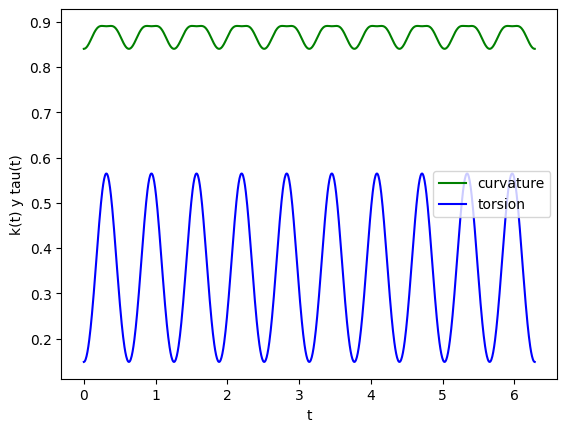

In [40]:
plt.plot(t_vals, k_vals, label='curvature', color='green')
plt.plot(t_vals, torsion_vals, label='torsion', color='blue')
plt.ylabel('k(t) y tau(t)')
plt.xlabel('t')
plt.legend()
plt.show()

### Point 6.3

- Add the vectors $\vec{T}(0),\; \vec{N}(0),\; \vec{B}(0)$ to the previous plot.

In [41]:
T = info['unit_da']
N = info['unit_dda']
B = info['unit_binorm_vec']

In [42]:
# substitute the values of omega and a
alpha_subs = (alpha[0].subs({omega: omega_val, a: a_val}), alpha[1].subs({omega: omega_val, a: a_val}), alpha[2].subs({omega: omega_val, a: a_val}))
T_subs = (T[0].subs({omega: omega_val, a: a_val}), T[1].subs({omega: omega_val, a: a_val}), T[2].subs({omega: omega_val, a: a_val}))
N_subs = (N[0].subs({omega: omega_val, a: a_val}), N[1].subs({omega: omega_val, a: a_val}), N[2].subs({omega: omega_val, a: a_val}))
B_subs = (B[0].subs({omega: omega_val, a: a_val}), B[1].subs({omega: omega_val, a: a_val}), B[2].subs({omega: omega_val, a: a_val}))

#3D plot of the torus
alpha_fn   = sp.lambdify(t, alpha_subs, 'numpy')
T_fn       = sp.lambdify(t, T_subs, 'numpy')
N_fn       = sp.lambdify(t, N_subs, 'numpy')
B_fn       = sp.lambdify(t, B_subs, 'numpy')

# evaluate the parametric curve
alpha_vals = np.array(alpha_fn(t_vals))
start      = np.array(alpha_fn(0))
T0         = np.array(T_fn(0))
N0         = np.array(N_fn(0))
B0         = np.array(B_fn(0))

In [43]:
#add the T, N and B vectors at t=0
fig1  = plot_arrow_plotly(start, start + T0, name='T vector at t=0')
data1 = plot_arrow_plotly(start, start + N0, retrieve_fig=False, name='N vector at t=0')
data2 = plot_arrow_plotly(start, start + B0, retrieve_fig=False, name='B vector at t=0')

fig1.add_trace(data1[0])
fig1.add_trace(data1[1])
fig1.add_trace(data2[0])
fig1.add_trace(data2[1])

# 3D plot of the parametric curve, as a line, colored as a parameter of t 
# with the colorbar showing the values of t
fig1.add_trace(go.Scatter3d(x=alpha_vals[0],
                           y=alpha_vals[1],
                           z=alpha_vals[2],
                           marker=dict(size=4,
                                       color=t_vals,
                                       colorscale='inferno',),
                           line=dict(color=t_vals,
                                     colorscale='inferno',
                                     width=2), 
                          ))

fig1.update_layout(title='Parametric curve',
                  scene=dict(xaxis_title='x',
                             yaxis_title='y',
                             zaxis_title='z'), 
                  width=800,
                  height=800, 
                  margin=dict(l=65, r=50, b=65, t=90), 
                  scene_aspectmode='cube',)

#update the limits of the axis
fig1.update_layout(scene=dict(xaxis=dict(range=[-7, 7],), 
                             yaxis=dict(range=[-7, 7],), 
                             zaxis=dict(range=[-7, 7],), 
                            ))

-----------
# Bibliography

- [Cross product](https://en.wikipedia.org/wiki/Cross_product)
- [Torsion of a curve](https://en.wikipedia.org/wiki/Torsion_of_a_curve)
- [Torsion](https://mathworld.wolfram.com/Torsion.html)
- [Triple product](https://en.wikipedia.org/wiki/Triple_product)
- [Curvature and torsion, explaination of the curvature equation](https://youtu.be/TnbRqkdVGso)
- [scipy.spatial.voronoi_plot_2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.voronoi_plot_2d.html)
- [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad)
- [Visualizacion-de-datos/Mapas.ipynb](https://github.com/nicoavilan/Visualizacion-de-datos/blob/main/Mapas.ipynb)
- [Geopandas Documentation](https://geopandas.org/en/stable/docs.html)
- [3D Scatter Plots in Python](https://plotly.com/python/3d-scatter-plots/#style-3d-scatter-plot)
- [3D Line Plots in Python](https://plotly.com/python/3d-line-plots/)
- [3D Surface Plots in Python](https://plotly.com/python/3d-surface-plots/)
